In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
     pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import hashlib
import random
from PIL import Image, ImageEnhance
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [50]:

train_df = pd.read_csv("/kaggle/input/sports-image-classification/dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/sports-image-classification/dataset/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print(train_df.head())


Train shape: (8227, 2)
Test shape: (2056, 1)
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket


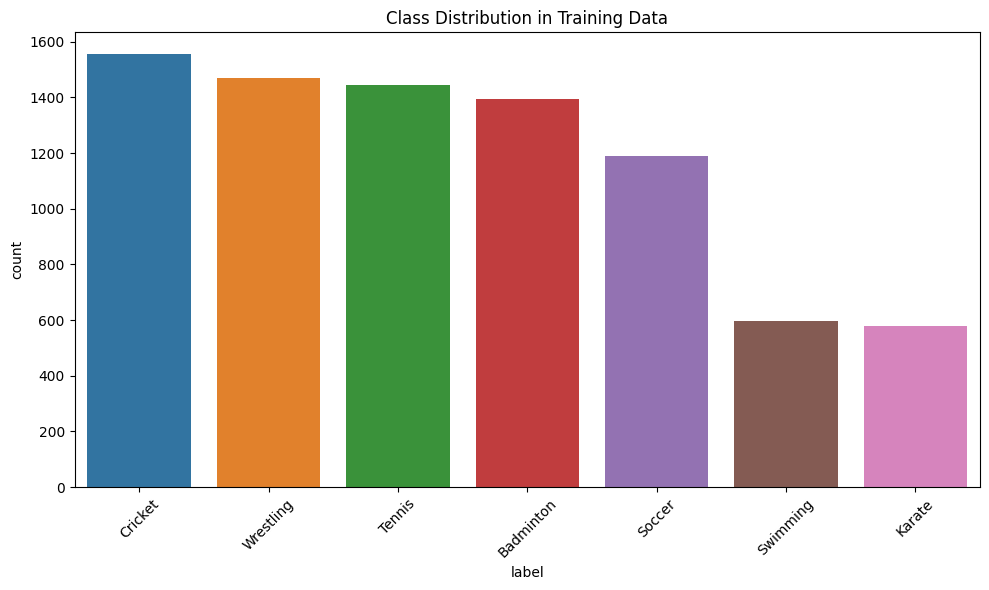

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


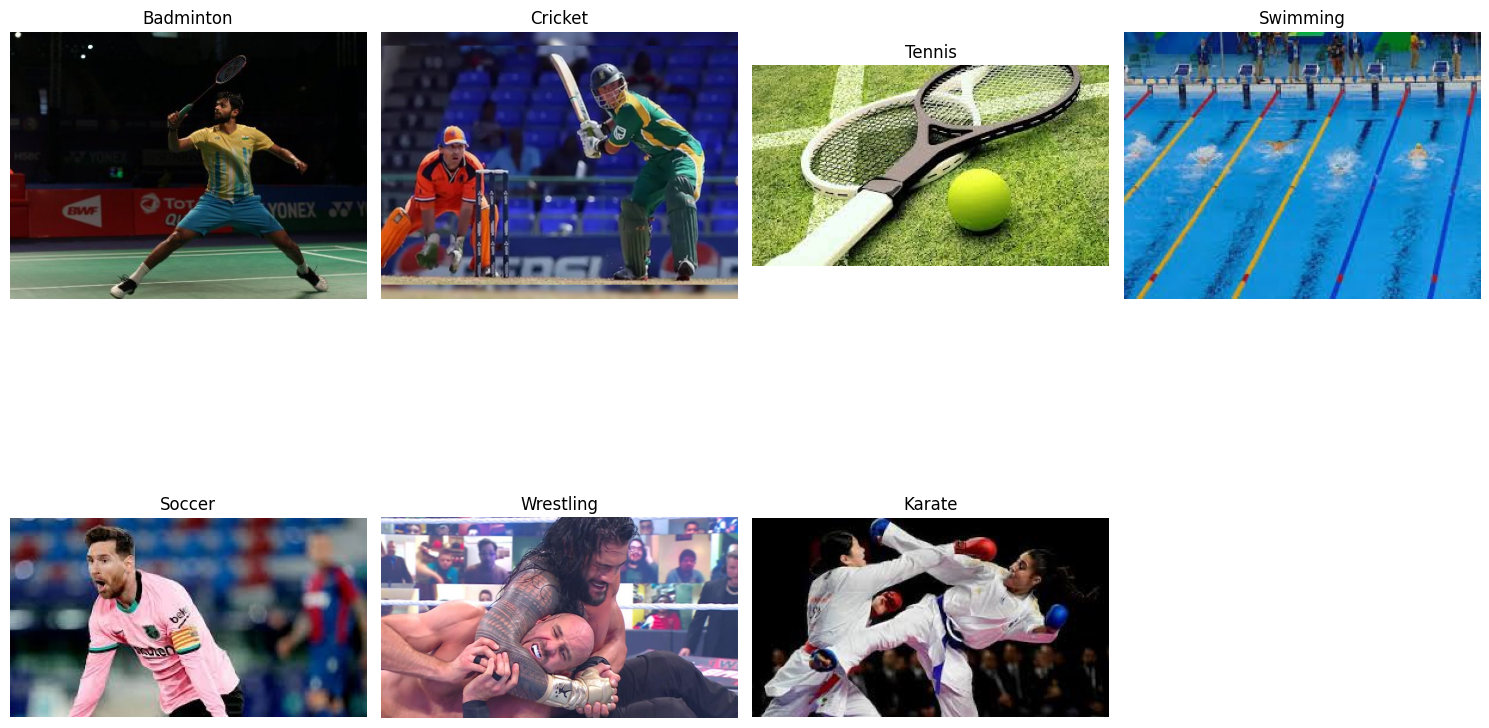

In [4]:

IMG_DIR = "/kaggle/input/sports-image-classification/dataset/train"
classes = train_df['label'].unique()
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    # Get one image from each class
    sample_img_id = train_df[train_df['label'] == cls]['image_ID'].iloc[0]
    img_path = os.path.join(IMG_DIR, sample_img_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Duplicates in image_id
duplicate_ids = train_df[train_df.duplicated("image_ID")]
print("Duplicate image_id entries:")
print(duplicate_ids)

# Remove duplicates if needed
train_df.drop_duplicates(subset="image_ID", inplace=True)
train_df.reset_index(drop=True, inplace=True)


Duplicate image_id entries:
Empty DataFrame
Columns: [image_ID, label]
Index: []


Found 2 exact duplicate image pairs.


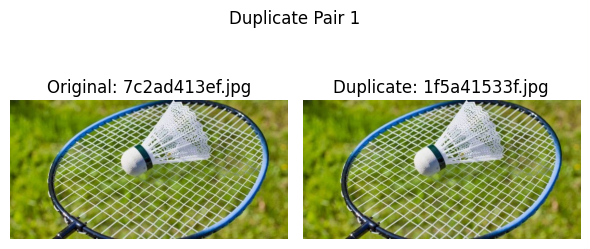

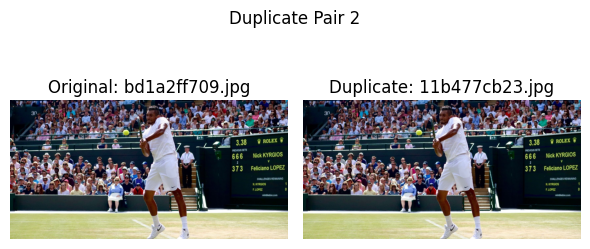

In [6]:
# find Duplicates 

def get_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

image_hashes = {}
duplicate_image_pairs = []  # Store (original, duplicate) pairs

for i, row in train_df.iterrows():
    img_path = IMG_DIR + '/' + row['image_ID']
    try:
        img_hash = get_image_hash(img_path)
        if img_hash in image_hashes:
            duplicate_image_pairs.append((image_hashes[img_hash], row['image_ID']))
        else:
            image_hashes[img_hash] = row['image_ID']
    except:
        continue

print(f"Found {len(duplicate_image_pairs)} exact duplicate image pairs.")

# Plot first few duplicate pairs
num_to_show = min(5, len(duplicate_image_pairs))
for i in range(num_to_show):
    img1_id, img2_id = duplicate_image_pairs[i]
    img1 = cv2.imread(IMG_DIR + '/' + img1_id)
    img2 = cv2.imread(IMG_DIR + '/' + img2_id)

    # Convert from BGR to RGB for matplotlib
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,3))
    plt.suptitle(f'Duplicate Pair {i+1}')
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f'Original: {img1_id}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f'Duplicate: {img2_id}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [7]:
# Step 1: Extract duplicate image IDs only (second in each pair)
duplicate_ids_to_remove = [dup for orig, dup in duplicate_image_pairs]

# Step 2: Remove them from the DataFrame
print(f"Removing {len(duplicate_ids_to_remove)} duplicate entries...")

train_df_cleaned = train_df[~train_df['image_ID'].isin(duplicate_ids_to_remove)].copy()
train_df_cleaned.reset_index(drop=True, inplace=True)

print(f"Dataset reduced from {len(train_df)} to {len(train_df_cleaned)} images.")

train_df_cleaned.to_csv("train_cleaned.csv", index=False)



Removing 2 duplicate entries...
Dataset reduced from 8227 to 8225 images.


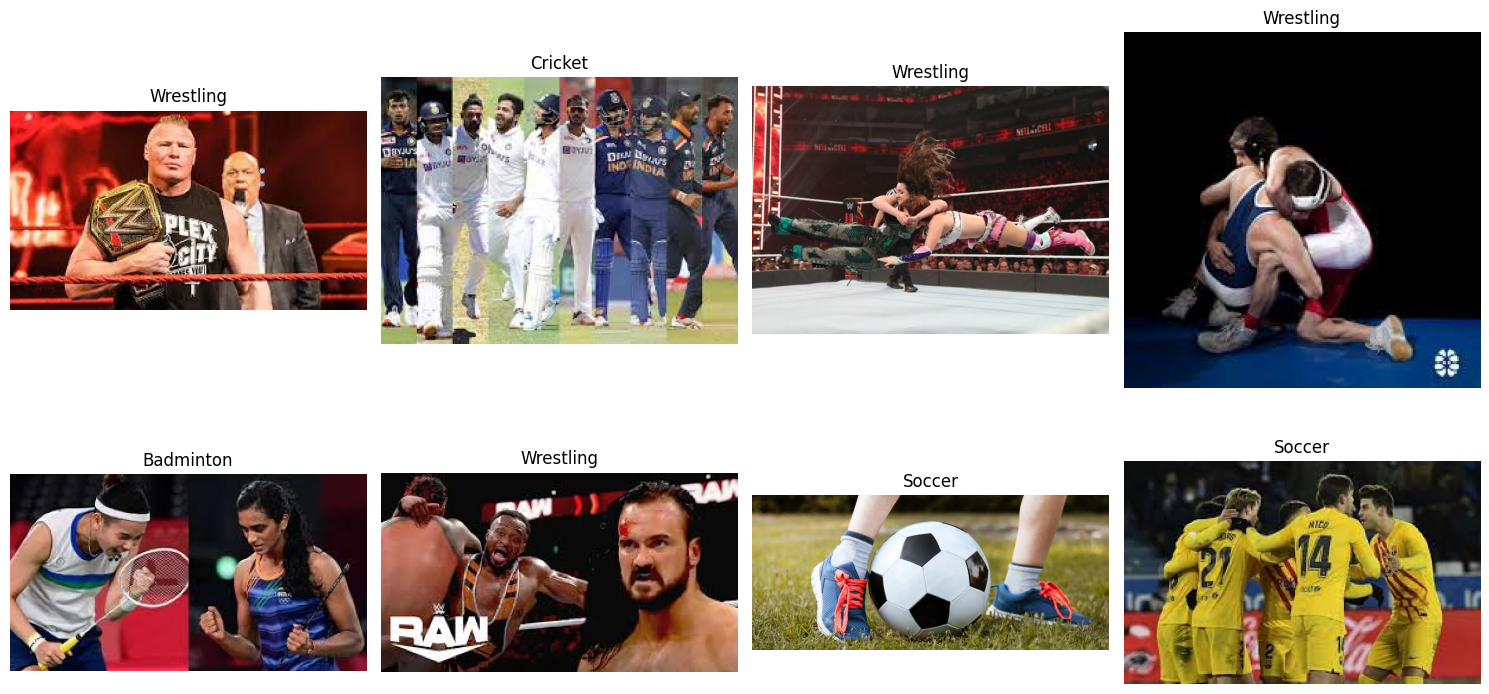

In [9]:

sample_rows = train_df.sample(8)
plt.figure(figsize=(15, 8))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_path = os.path.join(IMG_DIR, row['image_ID'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()


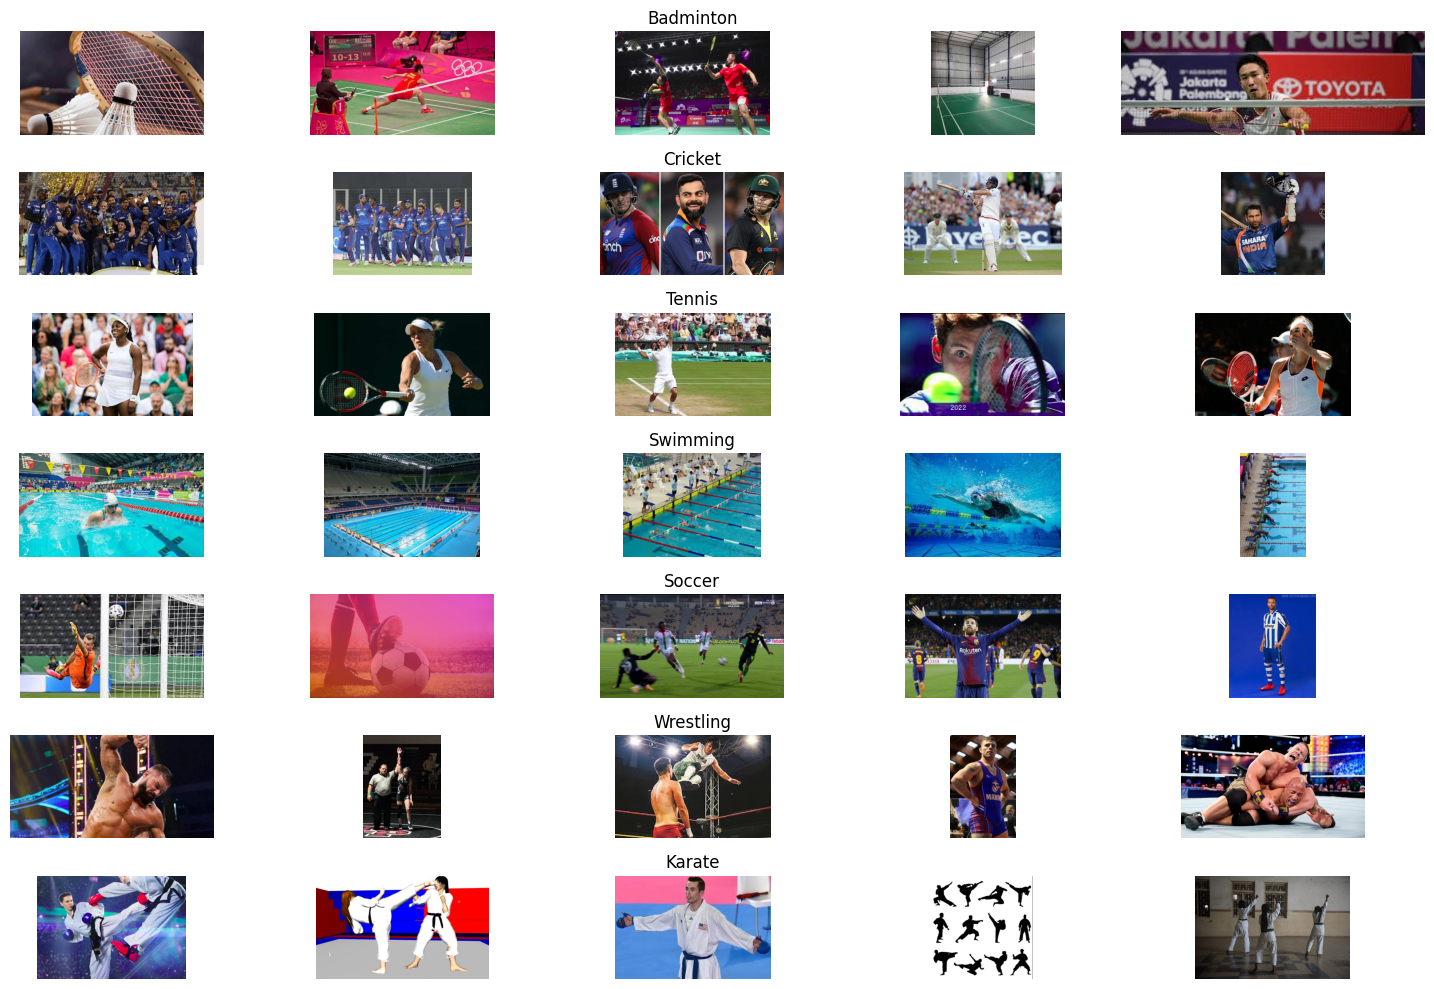

In [10]:

classes = train_df['label'].unique()
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    sample_imgs = train_df[train_df['label'] == cls].sample(5)['image_ID'].values
    for j, img_id in enumerate(sample_imgs):
        img_path = os.path.join(IMG_DIR, img_id)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), 5, i*5 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 2:
            plt.title(cls)

plt.tight_layout()
plt.show()


100%|██████████| 8227/8227 [00:30<00:00, 272.79it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


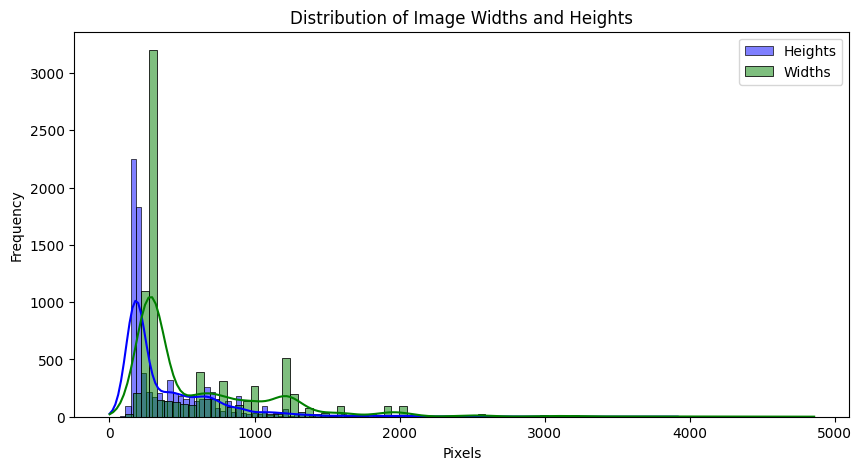

In [11]:
# Distribution of w, h
widths = []
heights = []

for img_id in tqdm(train_df['image_ID']):
    img_path = os.path.join(IMG_DIR, img_id)
    img = cv2.imread(img_path)
    if img is not None:
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)

plt.figure(figsize=(10,5))
sns.histplot(heights, kde=True, color='blue', label='Heights')
sns.histplot(widths, kde=True, color='green', label='Widths')
plt.legend()
plt.title("Distribution of Image Widths and Heights")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()


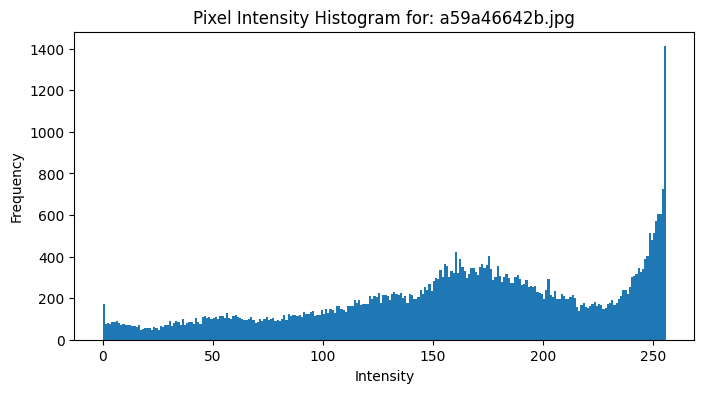

In [12]:
sample_img_id = train_df.sample(1)['image_ID'].values[0]
gray = cv2.imread(IMG_DIR+ '/'+ sample_img_id, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 4))
plt.hist(gray.ravel(), bins=256, range=[0, 256])
plt.title(f"Pixel Intensity Histogram for: {sample_img_id}")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


Generating augmented images...


100%|██████████| 8225/8225 [02:28<00:00, 55.24it/s]


Original dataset: 8225, After augmentation: 16450


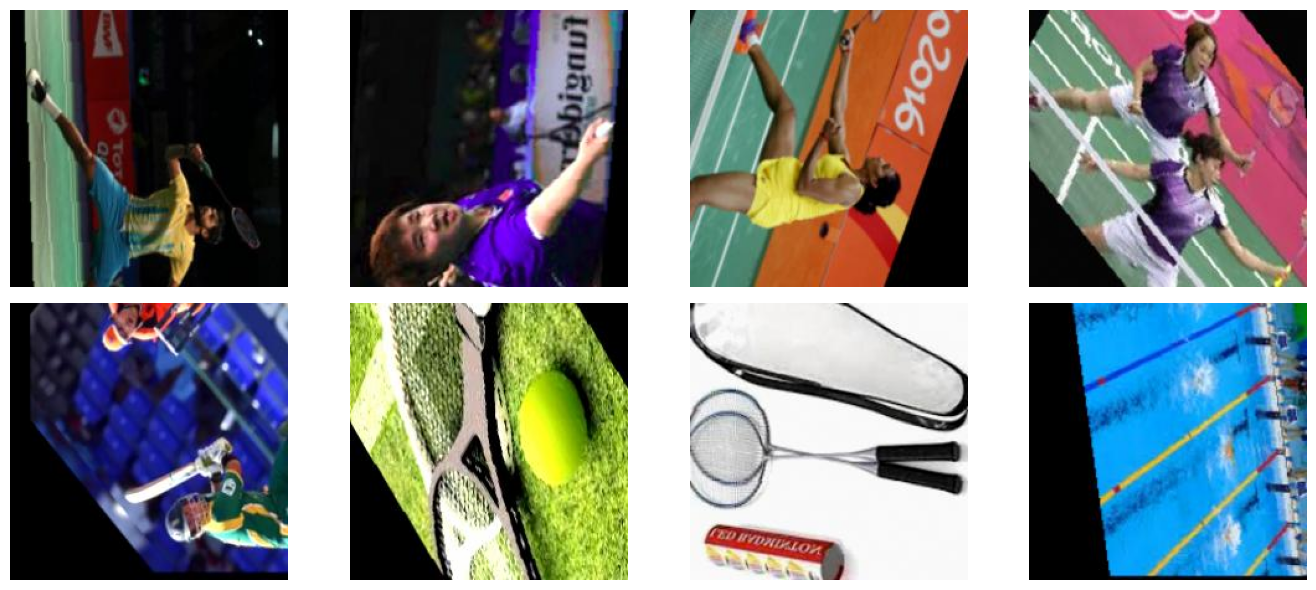

In [13]:

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Paths
ORIG_IMG_DIR = "/kaggle/input/sports-image-classification/dataset/train"
AUG_IMG_DIR = "/kaggle/working/augmented_images"
os.makedirs(AUG_IMG_DIR, exist_ok=True)

# Label mapping
label_to_idx = {label: idx for idx, label in enumerate(train_df_cleaned['label'].unique())}

# Custom noise function
def add_noise(image, noise_factor=0.1):
    image = np.array(image)
    noise = np.random.normal(0, noise_factor, image.shape)
    noisy_image = np.clip(image + noise, 0, 255)
    return Image.fromarray(noisy_image.astype(np.uint8))

# Data augmentation pipeline
augment_transform = transforms.Compose([
    # Rotation: Randomly rotate the image by 90 or 180 degrees
    transforms.Lambda(lambda x: x.rotate(random.choice([90, 45,65,180]))),
    
    # Translation: Randomly shift the image horizontally or vertically (10%)
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    
    # Scaling: Random crop with scale between 80% to 130%
    transforms.RandomResizedCrop(224, scale=(0.8, 1.3)),
    
    # Flipping: Horizontal and vertical flips
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    
    # Shearing: Apply affine shear of up to 10 degrees
    transforms.RandomAffine(0, shear=10),
    
    # Zooming: Adjust crop scale between 70% to 100%
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    
    # Brightness and contrast adjustment
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    
    # Add Gaussian noise
    transforms.Lambda(lambda x: add_noise(x, noise_factor=0.1)),
])

# Create augmented images and DataFrame
augmented_data = []

print("Generating augmented images...")
for i, row in tqdm(train_df_cleaned.iterrows(), total=len(train_df_cleaned)):
    orig_path = os.path.join(ORIG_IMG_DIR, row['image_ID'])
    try:
        image = Image.open(orig_path).convert('RGB')
        for j in range(1):  # Generate 1 augmentation per image (change to more if needed)
            aug_image = augment_transform(image)
            aug_filename = f"aug_{i}_{j}.jpg"
            aug_path = os.path.join(AUG_IMG_DIR, aug_filename)
            aug_image.save(aug_path)

            augmented_data.append({
                'image_ID': aug_filename,
                'label': row['label']
            })
    except:
        continue

# Create a DataFrame from the augmented images
augmented_df = pd.DataFrame(augmented_data)

# Combine with original data
combined_df = pd.concat([train_df_cleaned, augmented_df], ignore_index=True)
print(f"Original dataset: {len(train_df_cleaned)}, After augmentation: {len(combined_df)}")

# You can save this combined dataframe if needed
combined_df.to_csv("train_with_augmented.csv", index=False)

# Update IMG_DIR to point to combined original + augmented image folder
# We'll use both folders by pointing to a merged folder structure
FINAL_IMG_DIR = "/kaggle/working/combined_images"
os.makedirs(FINAL_IMG_DIR, exist_ok=True)

# Copy original images to combined folder (symbolic for Kaggle runtime)
for i, row in train_df_cleaned.iterrows():
    src = os.path.join(ORIG_IMG_DIR, row['image_ID'])
    dst = os.path.join(FINAL_IMG_DIR, row['image_ID'])
    if not os.path.exists(dst):
        os.system(f"cp '{src}' '{dst}'")

# Move augmented images
for i, row in augmented_df.iterrows():
    src = os.path.join(AUG_IMG_DIR, row['image_ID'])
    dst = os.path.join(FINAL_IMG_DIR, row['image_ID'])
    if not os.path.exists(dst):
        os.system(f"cp '{src}' '{dst}'")

# Function to plot augmented images
def plot_augmented_images(img_paths, n_images=8):
    """ Display a batch of augmented images """
    plt.figure(figsize=(14, 6))
    for i in range(n_images):
        img_path = img_paths[i]
        image = Image.open(img_path)
        plt.subplot(2, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

augmented_img_paths = [os.path.join(AUG_IMG_DIR, row['image_ID']) for i, row in augmented_df.iterrows()]
plot_augmented_images(augmented_img_paths, n_images=8)


In [73]:

# First split into 80% train and 20% temp (val + test)
train_df, temp_df = train_test_split(
    combined_df, 
    test_size=0.2, 
    stratify=combined_df['label'], 
    random_state=42
)

# Split the 20% temp into 10% val and 10% test
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)

# Check sizes
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

# Optionally save them
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)


Train set: 13160
Validation set: 1645
Test set: 1645


In [74]:
test_df.columns

Index(['image_ID', 'label'], dtype='object')

In [20]:

# Conv block with optional bottleneck and SE block
def conv_block(x, filters, kernel_size=3, strides=1, use_se=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    if use_se:
        # Squeeze-and-Excitation block
        se = layers.GlobalAveragePooling2D()(x)
        se = layers.Dense(filters // 8, activation='relu')(se)
        se = layers.Dense(filters, activation='sigmoid')(se)
        se = layers.Reshape((1, 1, filters))(se)
        x = layers.multiply([x, se])

    return x

2025-05-12 00:39:15.727929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747010355.948511      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747010356.010858      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
# training function

def train_model(
    train_df,
    val_df,
    final_img_dir,
    input_shape=(224, 224, 3),
    num_classes=7,
    batch_size=32,
    num_conv_blocks=6,
    dropout_rate=0.5,
    optimizer_name='adam',
    weight_decay=0.001,
    initial_lr=1e-4,
    lr_scheduler=True,
    epochs=30
):

    K.clear_session()

    # Dataset preparation
    def prepare_datasets(train_df, val_df, img_dir, img_size=(224, 224), batch_size=32):
        label_encoder = LabelEncoder()
        all_labels = pd.concat([train_df['label'], val_df['label']])
        label_encoder.fit(all_labels)

        train_df['encoded_label'] = label_encoder.transform(train_df['label'])
        val_df['encoded_label'] = label_encoder.transform(val_df['label'])

        def load_image(image_id, label):
            image_path = tf.strings.join([img_dir, image_id], separator=os.sep)
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, img_size)
            image = image / 255.0
            return image, label

        train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_ID'].values, train_df['encoded_label'].values))
        val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_ID'].values, val_df['encoded_label'].values))

        train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_ds, val_ds
        
        # CNN architecture
    def variable_cnn(input_shape, num_classes, num_blocks, dropout_rate, weight_decay):
        inputs = tf.keras.Input(shape=input_shape)
        x = inputs
        filters = 32
        for _ in range(num_blocks):
            x = conv_block(x, filters, use_se=True)
            x = conv_block(x, filters, use_se=True)
            x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
            filters *= 2
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512, activation='relu',
                                  kernel_regularizer=regularizers.l2(weight_decay))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
        return tf.keras.Model(inputs, outputs)

    # Optimizer + LR scheduler
    def compile_model(model, optimizer_name, initial_lr, lr_scheduler):
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
        elif optimizer_name == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=initial_lr, momentum=0.9)
        elif optimizer_name == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_lr)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        if lr_scheduler == 'exponential':
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_lr, decay_steps=1000, decay_rate=0.9, staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        elif lr_scheduler == 'step':
            lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                boundaries=[1000, 2000], values=[initial_lr, initial_lr * 0.5, initial_lr * 0.1])
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        elif lr_scheduler == 'cosine':
            lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=initial_lr, decay_steps=3000, alpha=0.1)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    # Training loop
    def train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, weight_decay, lr_scheduler):
        callbacks = [
            ModelCheckpoint(filepath=f'/kaggle/working/best_model_one.keras',
                            monitor='val_loss', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
        ]
        if lr_scheduler is True:
            callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6))

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history

    # Prepare data
    train_ds, val_ds = prepare_datasets(train_df, val_df, final_img_dir, img_size=input_shape[:2], batch_size=batch_size)

    # Handle multiple weight decays
    if isinstance(weight_decay, list):
        results = {}
        for wd in weight_decay:
            model = variable_cnn(input_shape, num_classes, num_conv_blocks, dropout_rate, wd)
            model = compile_model(model, optimizer_name, initial_lr, lr_scheduler)
            history = train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, wd, lr_scheduler)
            results[wd] = history
        return results

    # Single weight decay
    model = variable_cnn(input_shape, num_classes, num_conv_blocks, dropout_rate, weight_decay)
    model = compile_model(model, optimizer_name, initial_lr, lr_scheduler)
    history = train_and_evaluate(model, train_ds, val_ds, batch_size, epochs, weight_decay, lr_scheduler)

    return model, history






In [ ]:
results = {}

# 5. L2 Weight Decay
for weight_decay in [1e-5, 0.001]:
    print(f"\n🔧 Training with weight_decay={weight_decay}")
    model, history = train_model(
        train_df=train_df,
        val_df=val_df,
        final_img_dir=FINAL_IMG_DIR,
        weight_decay=weight_decay
    )
    model.save(f"/kaggle/working/model_l2_{weight_decay}.h5")
    results[f'l2_{weight_decay}'] = history.history


🔧 Training with weight_decay=1e-05


I0000 00:00:1747010636.120320      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30


I0000 00:00:1747010657.671583   32983 service.cc:148] XLA service 0x78e61805b2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747010657.672425   32983 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747010659.489215   32983 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/412 ━━━━━━━━━━━━━━━━━━━━ 4:40:00 41s/step - accuracy: 0.0312 - loss: 3.9551

I0000 00:00:1747010678.667368   32983 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4606 - loss: 3.1109
Epoch 1: val_loss improved from inf to 3.39593, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 106s 158ms/step - accuracy: 0.4608 - loss: 3.1104 - val_accuracy: 0.3143 - val_loss: 3.3959 - learning_rate: 1.0000e-04
Epoch 2/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6391 - loss: 2.5661
Epoch 2: val_loss improved from 3.39593 to 2.39194, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.6391 - loss: 2.5658 - val_accuracy: 0.6553 - val_loss: 2.3919 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6800 - loss: 2.3011
Epoch 3: val_loss improved from 2.39194 to 2.16225, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.6800 - loss: 2.3008 - val_accuracy: 0.6930 - val_loss: 2.1622 - learning_rate: 1.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4670 - loss: 3.7655
Epoch 1: val_loss improved from inf to 3.68383, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 89s 145ms/step - accuracy: 0.4672 - loss: 3.7650 - val_accuracy: 0.3757 - val_loss: 3.6838 - learning_rate: 1.0000e-04
Epoch 2/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6360 - loss: 3.1756
Epoch 2: val_loss improved from 3.68383 to 2.95029, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.6360 - loss: 3.1752 - val_accuracy: 0.6602 - val_loss: 2.9503 - learning_rate: 1.0000e-04
Epoch 3/30
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6722 - loss: 2.8397
Epoch 3: val_loss improved from 2.95029 to 2.70499, saving model to /kaggle/working/best_model_one.keras
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.6722 - loss: 2.8393 - val_accuracy: 0.6699 - val_loss: 2.7050 - learnin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30


In [53]:
def filter_existing_images(df, img_dir):
    df['full_path'] = df['image_ID'].apply(lambda x: os.path.join(img_dir, x))
    df = df[df['full_path'].apply(os.path.exists)]
    df = df.drop(columns='full_path')
    return df

train_df = filter_existing_images(train_df, FINAL_IMG_DIR)
val_df = filter_existing_images(val_df, FINAL_IMG_DIR)


In [54]:
results2 = {}
#6. Learning Rate
for lr_schedule in ['step', True]:
    print(f"\n Training with learning_rate={lr_schedule}")
    model, history = train_model(
        train_df=train_df,
        val_df=val_df,
        final_img_dir=FINAL_IMG_DIR,
        initial_lr= 1e-4,
        lr_scheduler= lr_schedule
    )
    model.save(f"/kaggle/working/model_lr_{lr_schedule}.h5")
    results2[f'lr_{lr_schedule}'] = history.history



 Training with learning_rate=step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4831 - loss: 3.7455
Epoch 1: val_loss improved from inf to 5.06095, saving model to /kaggle/working/best_model_one.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 78s 180ms/step - accuracy: 0.4834 - loss: 3.7445 - val_accuracy: 0.1757 - val_loss: 5.0609
Epoch 2/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6864 - loss: 3.1006
Epoch 2: val_loss improved from 5.06095 to 3.48502, saving model to /kaggle/working/best_model_one.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.6865 - loss: 3.1000 - val_accuracy: 0.4888 - val_loss: 3.4850
Epoch 3/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7359 - loss: 2.8470
Epoch 3: val_loss improved from 3.48502 to 3.14022, saving model to /kaggle/working/best_model_one.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.7360 - loss: 2.8465 - val_accuracy: 0.5903 - val_loss: 3.1402
Epoch 4/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4887 - loss: 3.7212
Epoch 1: val_loss improved from inf to 4.82888, saving model to /kaggle/working/best_model_one.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 74s 168ms/step - accuracy: 0.4891 - loss: 3.7203 - val_accuracy: 0.1690 - val_loss: 4.8289 - learning_rate: 1.0000e-04
Epoch 2/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6832 - loss: 3.1078
Epoch 2: val_loss improved from 4.82888 to 3.43422, saving model to /kaggle/working/best_model_one.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.6834 - loss: 3.1073 - val_accuracy: 0.5058 - val_loss: 3.4342 - learning_rate: 1.0000e-04
Epoch 3/30
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7395 - loss: 2.8483
Epoch 3: val_loss improved from 3.43422 to 3.23418, saving model to /kaggle/working/best_model_one.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.7395 - loss: 2.8479 - val_accuracy: 0.5793 - val_loss: 3.2342 - learnin

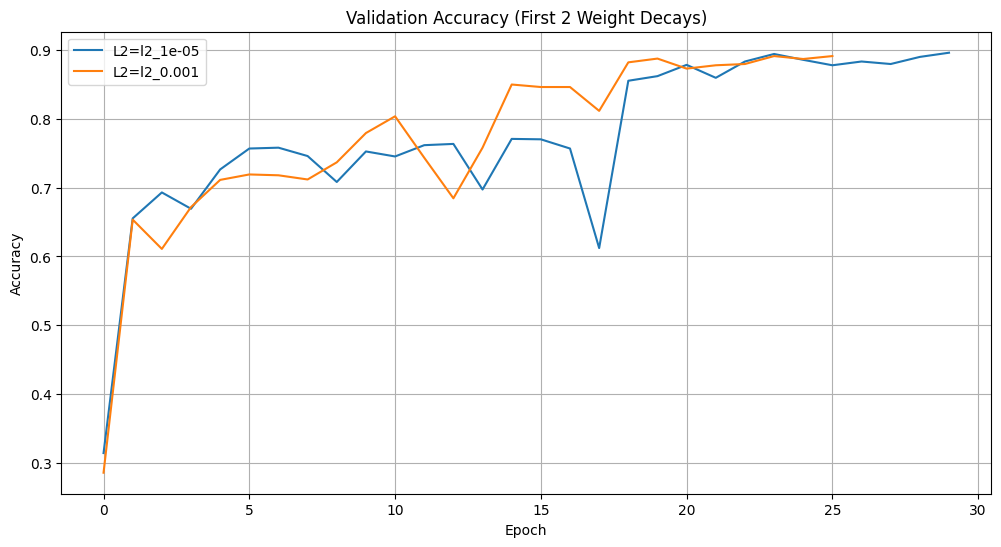

In [77]:
# Plot L2 with diff weight decays

keys = list(results.keys())[:2]  # Take only the first 2 keys

plt.figure(figsize=(12, 6))
for key in keys:
    plt.plot(results[key]['val_accuracy'], label=f'L2={key}')

plt.title('Validation Accuracy (First 2 Weight Decays)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

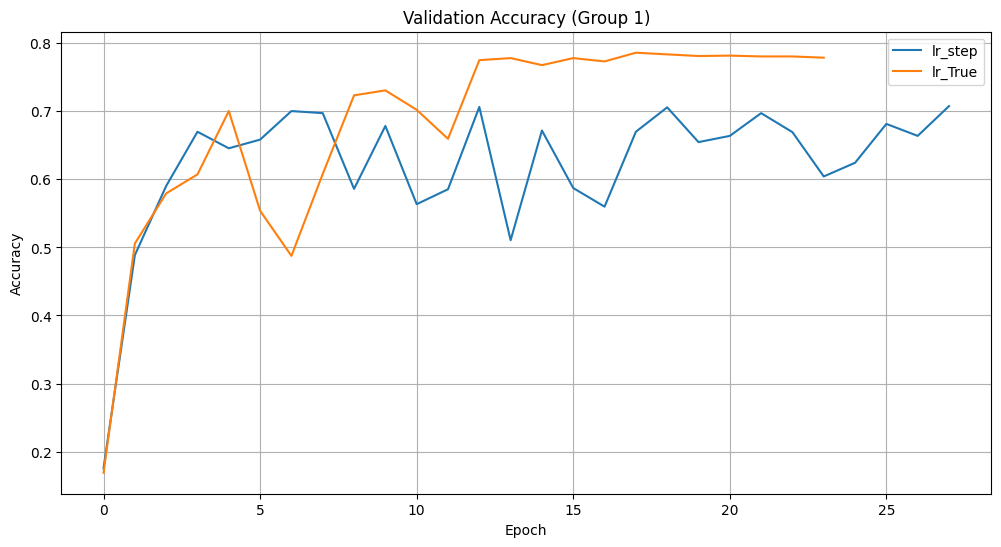

In [57]:
# Plot LR step and adaptive

keys = list(results2.keys())
group_size = 2

for i in range(0, len(keys), group_size):
    group_keys = keys[i:i + group_size]
    plt.figure(figsize=(12, 6))
    for key in group_keys:
        plt.plot(results2[key]['val_accuracy'], label=key)
    
    plt.title(f'Validation Accuracy (Group {i // group_size + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [78]:
# Config summary 
summary_data = []

for key, value in results.items():
    best_val_acc = max(value['val_accuracy'])  
    summary_data.append({
        'Configuration': key,
        'Best Val Accuracy': round(best_val_acc, 4),
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='Best Val Accuracy', ascending=False).reset_index(drop=True)

# Print only top 2 configurations
print(summary_df.head(2))

  Configuration  Best Val Accuracy
0      l2_1e-05             0.8960
1      l2_0.001             0.8912


In [61]:
# config summary

summary_data = []

for key, value in results2.items():
    best_val_acc = max(value['val_accuracy'])
    summary_data.append({
        'Configuration': key,
        'Best Val Accuracy': round(best_val_acc, 4),
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='Best Val Accuracy', ascending=False).reset_index(drop=True)
print(summary_df)

  Configuration  Best Val Accuracy
0       lr_True             0.7860
1       lr_step             0.7076


In [62]:
def prepare_test_dataset(test_df, img_dir, img_size=(224, 224), batch_size=32, label_encoder=None):
    if label_encoder is None:
        raise ValueError("You must pass the same LabelEncoder used in training.")

    test_df = test_df.copy()
    test_df['encoded_label'] = label_encoder.transform(test_df['label'])

    def load_image(image_id, label):
        image_path = tf.strings.join([img_dir, image_id], separator=os.sep)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = image / 255.0
        return image, label
        
    test_ds = tf.data.Dataset.from_tensor_slices((test_df['image_ID'].values, test_df['encoded_label'].values))
    test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return test_ds

def model_evaluation(model, test_df, final_img_dir, input_shape, label_encoder, history=None, batch_size=32):
    # Prepare test dataset
    test_ds = prepare_test_dataset(
        test_df=test_df,
        img_dir=final_img_dir,
        img_size=input_shape[:2],
        batch_size=batch_size,
        label_encoder=label_encoder
    )
    # Evaluate model
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Plot training/validation accuracy if history is provided
    if history:
        acc = history.history.get('accuracy')
        val_acc = history.history.get('val_accuracy')
        plt.plot(acc, label='Train Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    return test_acc

In [65]:
label_encoder = LabelEncoder()
all_labels = pd.concat([train_df['label'], val_df['label']])
label_encoder.fit(all_labels)

LabelEncoder()

In [68]:
test_df.columns

Index(['image_ID'], dtype='object')

In [75]:
from tensorflow.keras.models import load_model
test_results = {}

# Evaluate models saved during weight decay tuning
for weight_decay in [1e-5, 0.001]:
    model_path = f"/kaggle/working/model_l2_{weight_decay}.h5"
    model = load_model(model_path)
    
    print(f"\n Evaluating model with weight_decay={weight_decay}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=None
    )
    test_results[f'l2_{weight_decay}'] = test_acc

# Evaluate models saved during learning rate scheduler tuning
for lr_schedule in ['step', True]:
    model_path = f"/kaggle/working/model_lr_{lr_schedule}.h5"
    model = load_model(model_path)
    
    print(f"\n Evaluating model with learning_rate scheduler={lr_schedule}")
    test_acc = model_evaluation(
        model=model,
        test_df=test_df,
        final_img_dir=FINAL_IMG_DIR,
        input_shape=(224, 224, 3),
        label_encoder=label_encoder,
        history=None
    )
    test_results[f'lr_{lr_schedule}'] = test_acc



 Evaluating model with weight_decay=1e-05
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8993 - loss: 0.8266
Test Accuracy: 0.8973
Test Loss: 0.8074

 Evaluating model with weight_decay=0.001
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9041 - loss: 0.9273
Test Accuracy: 0.8991
Test Loss: 0.9392

 Evaluating model with learning_rate scheduler=step
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.7091 - loss: 1.8836
Test Accuracy: 0.6863
Test Loss: 1.9578

 Evaluating model with learning_rate scheduler=True
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8258 - loss: 2.0510
Test Accuracy: 0.7957
Test Loss: 2.1555
